In [1]:
import os
import gc
import time
import pickle
from pathlib import Path
import numpy as np
import pandas as ps

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_folder = Path('..') / 'data'

with open(str(data_folder / 'processed' / 'train_3.pkl'), 'rb') as f:
    train_df = pickle.load(f)
    
with open(str(data_folder / 'processed' / 'test_3.pkl'), 'rb') as f:
    test_df = pickle.load(f)

# test_df = ps.read_csv(data_folder / 'processed' / 'test.csv')
# train_df = ps.read_csv(data_folder / 'processed' / 'train.csv')

print('Train shapes:', train_df.shape)
print('Test shapes:', test_df.shape)

Train shapes: (354851, 100)
Test shapes: (202614, 99)


In [3]:
# train_df.columns.tolist()

['OrderID',
 'ChannelID_1',
 'ChannelID_2',
 'ChannelID_3',
 'ChannelID_4',
 'ChannelID_5',
 'GroupID_1',
 'GroupID_2',
 'GroupID_3',
 'GroupID_4',
 'GroupID_5',
 'GroupID_6',
 'GroupID_7',
 'GroupID_8',
 'GroupID_9',
 'GroupID_10',
 'GroupID_11',
 'GroupID_12',
 'GroupID_13',
 'GroupID_14',
 'GroupID_15',
 'GroupID_16',
 'GroupID_17',
 'GroupID_18',
 'GroupID_19',
 'GroupID_20',
 'GroupID_21',
 'GroupID_22',
 'GroupID_23',
 'GroupID_24',
 'GroupID_25',
 'GroupID_26',
 'GroupID_27',
 'GroupID_28',
 'GroupID_29',
 'GroupID_30',
 'GroupID_31',
 'GroupID_32',
 'GroupID_33',
 'GroupID_34',
 'GroupID_35',
 'GroupID_36',
 'GroupID_37',
 'GroupID_38',
 'GroupID_39',
 'GroupID_40',
 'GroupID_41',
 'GroupID_42',
 'GroupID_43',
 'GroupID_44',
 'GroupID_45',
 'GroupID_46',
 'GroupID_47',
 'GroupID_48',
 'GroupID_49',
 'Cluster_1',
 'Cluster_2',
 'Cluster_3',
 'Cluster_4',
 'Cluster_5',
 'Cluster_6',
 'Cluster_7',
 'Cluster_8',
 'Cluster_9',
 'Cluster_10',
 'Cluster_11',
 'Cluster_12',
 'Cluster_1

In [4]:
target = 'CancelFlag'
drop_features = {
    'OrderID', 
    'Date_day', 'Date_month', 'Date_year',
    'OrderDate_day', 'OrderDate_month', 'OrderDate_year',
    target
}
features2use = [f for f in train_df.columns if f not in drop_features]
# categorical_features = [
#     'ChannelID',
#     'OrderID',
#     'MaterialID',
#     'GroupID',
#     'Cluster',
#     'DeliveryType',
# #     'StartInterval',
# #     'EndInterval',
# #     'Date_weekday',
# #     'OrderDate_weekday',
# #     'Date_day',
# #     'Date_month',
# #     'Date_year',
# #     'OrderDate_day',
# #     'OrderDate_month',
# #     'OrderDate_year',
# ]
categorical_features = []

In [5]:
test_df[target] = 0
# train_df = train_df.iloc[:100_000]

In [6]:
def make_predictions(folds, train_dframe, test_dframe, model_params, 
                     n_estimators=50_000, n_jobs=12, 
                     verbose=10_000, early_stopping_rounds=200):

    X, y = train_dframe[features2use], train_dframe[target]    
    P, P_y = test_dframe[features2use], train_df[target]  
    num_folds = folds.n_splits
    
    oof_preds = np.zeros((len(train_dframe), 1))
    predictions = np.zeros((len(test_dframe), 1))
    
    feature_importance = ps.DataFrame.from_dict({
        'feature': features2use,
        'importance': np.zeros(len(features2use))
    })
    scores = []
    
    for fold_, (train_idx, valid_idx) in enumerate(folds.split(X, y.values)):
        print()
        print(f'[{time.ctime()}] Fold: {fold_ + 1}/{num_folds}', flush=True)
        
        train_x, train_y = X.iloc[train_idx,:], y[train_idx]
        valid_x, valid_y = X.iloc[valid_idx,:], y[valid_idx]
#         pos_weight = np.sum(y == 0) / np.sum(y == 1)
#         print(f'Positive weight - {pos_weight}')
            
        print('Train & val shapes -', len(train_x), len(valid_y), flush=True)
        
        model = lgb.LGBMClassifier(
            **model_params, 
            n_estimators=n_estimators, 
            n_jobs=n_jobs,
#             scale_pos_weight=pos_weight,
        )
        model.fit(
            train_x, train_y,
            eval_set=[(train_x, train_y), (valid_x, valid_y)],
            early_stopping_rounds=early_stopping_rounds,
            verbose=verbose,
            categorical_feature=categorical_features
        )
        feature_importance['importance'] += model.feature_importances_ / num_folds
        
        valid_preds = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
        oof_preds[valid_idx] = valid_preds.reshape(-1, 1)
        
        # store fold scores
        scores.append(roc_auc_score(valid_y.values, valid_preds))
        
        test_preds = model.predict_proba(P, num_iteration=model.best_iteration_)[:, 1]
        predictions += test_preds.reshape(-1, 1)
    
    test_dframe[target] = predictions / num_folds
    
    print()
    print(f'Folds score - {np.mean(scores):.6f} +- {np.std(scores):.6f}', flush=True)
    print()
    
    return test_dframe, oof_preds, feature_importance

In [7]:
params = {
#     'num_leaves': 491,
#     'min_child_weight': 0.03454472573214212,
#     'feature_fraction': 0.3797454081646243,
#     'bagging_fraction': 0.4181193142567742,
#     'min_data_in_leaf': 106,
    'objective': 'binary',
    'max_depth': -1,
    'learning_rate': 0.005,
    'boosting_type': 'gbdt',
    'bagging_seed': 11,
    'metric': 'auc',
    'verbosity': -1,
#     'reg_alpha': 0.3899927210061127,
#     'reg_lambda': 0.6485237330340494,
    'random_state': 47,
}
folds = StratifiedKFold(n_splits=11, random_state=2019)

In [8]:
%%time
test_df, oof_preds, fi = make_predictions(
    folds, 
    train_df, test_df,
    params, 
    n_jobs=os.cpu_count(), 
    verbose=500, 
    early_stopping_rounds=500
)


[Sun Nov  3 17:12:31 2019] Fold: 1/11
Train & val shapes - 322591 32260
Training until validation scores don't improve for 500 rounds.
[500]	training's auc: 0.746267	valid_1's auc: 0.706486
[1000]	training's auc: 0.75989	valid_1's auc: 0.715649
[1500]	training's auc: 0.769877	valid_1's auc: 0.717777
[2000]	training's auc: 0.778892	valid_1's auc: 0.719094
[2500]	training's auc: 0.786656	valid_1's auc: 0.7195
[3000]	training's auc: 0.793811	valid_1's auc: 0.720108
[3500]	training's auc: 0.80032	valid_1's auc: 0.720734
[4000]	training's auc: 0.806452	valid_1's auc: 0.721404
[4500]	training's auc: 0.812182	valid_1's auc: 0.72231
[5000]	training's auc: 0.817444	valid_1's auc: 0.722998
[5500]	training's auc: 0.822534	valid_1's auc: 0.723705
[6000]	training's auc: 0.827627	valid_1's auc: 0.724687
[6500]	training's auc: 0.832711	valid_1's auc: 0.725392
[7000]	training's auc: 0.837042	valid_1's auc: 0.726002
[7500]	training's auc: 0.841273	valid_1's auc: 0.726482
[8000]	training's auc: 0.84521

In [9]:
fi = fi.sort_values(by='importance', ascending=False)

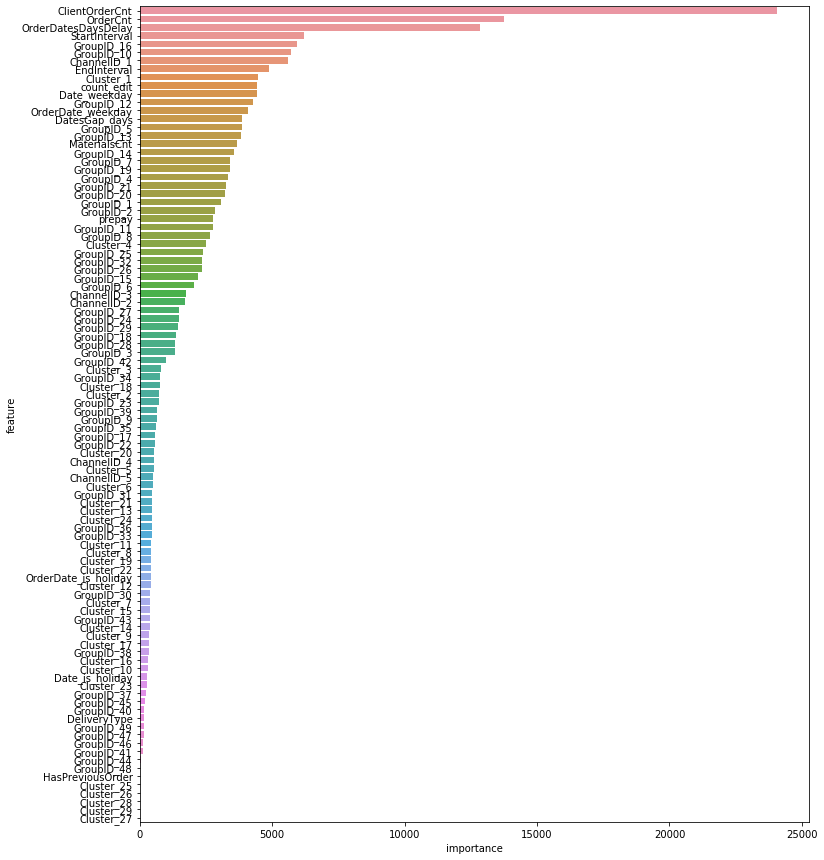

In [10]:
plt.figure(figsize=(12, 15))
sbn.barplot(x='importance', y='feature', data=fi);

In [11]:
print(test_df.shape)
test_df.head()

(202614, 100)


,OrderID,ChannelID_1,ChannelID_2,ChannelID_3,ChannelID_4,ChannelID_5,GroupID_1,GroupID_2,GroupID_3,GroupID_4,...,Date_is_holiday,Date_weekday,OrderDate_is_holiday,OrderDate_weekday,DatesGap_days,ClientOrderCnt,HasPreviousOrder,OrderDatesDaysDelay,MaterialsCnt,CancelFlag
0,90102211131,3,0,0,0,0,0,0,0,0,...,False,4,False,4,0,26,True,0,3,0.133146
1,90102211133,23,0,0,0,0,2,1,0,1,...,False,5,False,4,1,12,True,0,23,0.092496
2,90102216055,1,0,0,0,0,1,0,0,0,...,False,3,False,2,1,24,True,0,1,0.174843
3,90102216081,1,0,0,0,0,1,0,0,0,...,False,4,False,3,1,24,True,1,1,0.189437
4,90102216084,6,0,0,0,0,0,0,0,0,...,False,5,False,3,2,5,True,0,6,0.259883


In [12]:
t = test_df.copy()

In [13]:
res = t.groupby('OrderID').agg({'CancelFlag': 'mean'}).reset_index().rename(columns={'OrderID': 'ID', 'CancelFlag': 'Score'})
res['ID'] = res['ID'].map(lambda item: f'{item} ')
print(res.shape)
res.head()

(202614, 2)


,ID,Score
0,90102211131,0.133146
1,90102211133,0.092496
2,90102216055,0.174843
3,90102216081,0.189437
4,90102216084,0.259883


In [14]:
empty_df = ps.read_csv(data_folder / 'empty.csv')
print(empty_df.shape)
empty_df.head()

(202614, 2)


,ID,Score
0,90102211131,0.5
1,90102211133,0.5
2,90102216055,0.5
3,90102216081,0.5
4,90102216084,0.5


In [15]:
res.to_csv('../submission/dummy_3.csv', index=False)